In [1]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

2022-04-06 19:20:44.738960: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 19:20:44.738992: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Loading the relevant datasets (15/100)

(15026, 4)
(4696, 4)
(3757, 4)
['age' 'ethnicity' 'gender' 'img_name']
Train Gender Distribution:
0    0.52336
1    0.47664
Name: gender, dtype: float64

Test Gender Distribution:
0    0.522998
1    0.477002
Name: gender, dtype: float64

Val Gender Distribution:
0    0.523024
1    0.476976
Name: gender, dtype: float64

Train Ethnicity Distribution:
0    0.424065
1    0.190936
3    0.167976
2    0.145481
4    0.071543
Name: ethnicity, dtype: float64

Test Eethnicity Distribution:
0    0.423978
1    0.190801
3    0.168228
2    0.145443
4    0.071550
Name: ethnicity, dtype: float64

Val Eethnicity Distribution:
0    0.424009
1    0.190844
3    0.168219
2    0.145595
4    0.071334
Name: ethnicity, dtype: float64



<AxesSubplot:>

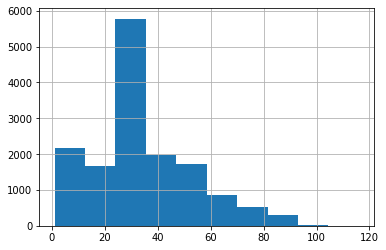

In [2]:
# load the datasets using the csv files train, val and test 
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
val = pd.read_csv('./data/val.csv')

# print the shapes of the dataframes 
print(train.shape)
print(test.shape)
print(val.shape)

# print the column names from either one of the dataframes 
print(train.columns.values)

# print the proportional distribution of gender in all three datasets(i.e., number of male and female) 
print(f"Train Gender Distribution:\n{train['gender'].value_counts() / len(train)}\n")
print(f"Test Gender Distribution:\n{test['gender'].value_counts() / len(test)}\n")
print(f"Val Gender Distribution:\n{val['gender'].value_counts() / len(val)}\n")

# print the proportional distribution of ethnicity in all three datasets 
print(f"Train Ethnicity Distribution:\n{train['ethnicity'].value_counts() / len(train)}\n")
print(f"Test Eethnicity Distribution:\n{test['ethnicity'].value_counts() / len(test)}\n")
print(f"Val Eethnicity Distribution:\n{val['ethnicity'].value_counts() / len(val)}\n")

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are: 
train['age'].hist()

#### Create the ImageDataGenerators (22/100)

In [3]:
def make_directories():
    d = datetime.datetime.today()
    timestamp = d.strftime('%Y%m%d_%H%M%S')
    # folder to store the tensorboard logs
    tensorlog_folder = os.path.join(os.path.curdir, 'logs', timestamp)
    # folder to store the trained models
    checkpoint_folder = os.path.join(os.path.curdir, 'models', timestamp)

    os.mkdir(tensorlog_folder)
    os.mkdir(checkpoint_folder)

    return checkpoint_folder, tensorlog_folder

Found 15026 validated image filenames.
Found 3757 validated image filenames.
Found 4696 validated image filenames.
26
4
1


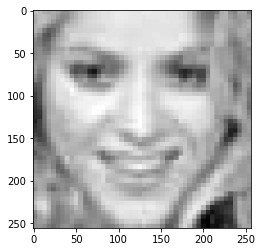

In [4]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
# batch_size = train.shape[0]

batch_size = 11

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
   rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    dtype=None
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
train_generator = train_img_gen.flow_from_dataframe(
  dataframe=train,
  directory='./data/images/train/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  seed = SEED,
)



# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of th eaugmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
    rescale=1./255
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
val_generator = val_img_gen.flow_from_dataframe(
  dataframe=val,
  directory='./data/images/val/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  shuffle=False,
  seed = SEED,
)

# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
test_img_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_img_gen.flow_from_dataframe(
  dataframe=test,
  directory='./data/images/test/',
  x_col='img_name',
  y_col=['age','ethnicity','gender'],
  class_mode='multi_output',
  color_mode='grayscale',
  batch_size=batch_size,
  shuffle=False,
)


# enumerate through the validation data generator created above and plot first grayscale image 
# (2)
tmpx = enumerate(val_generator)
for i, element in tmpx:
    if i == 8:
      print(element[1][0][i])
      print(element[1][1][i])
      print(element[1][2][i])
      plt.imshow(element[0][i], cmap = 'gray')
      break

#### Create the model (44/100)

In [5]:
# specify the model input with the required shape 
# (1)
in_shape = keras.Input(shape=(256, 256, 1))

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
# TODO

leaky_relu = tf.keras.activations.sigmoid
# activation = tf.keras.layers.softmax()

layer1 = tf.keras.layers.Conv2D(16, (2,2), activation=leaky_relu, name="layer1")
layer2 = tf.keras.layers.MaxPool2D(2,2, name="layer2")
layer3 = tf.keras.layers.Flatten(name="layer3")
layer4 = tf.keras.layers.Dense(units=128, activation = leaky_relu, name="layer4")
layer5 = tf.keras.layers.Dense(units=128, activation = leaky_relu, name="layer5")

sharedLayers = layer5(layer4(layer3(layer2(layer1(in_shape)))))


# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age
# TODO

ageTaskLayer = tf.keras.layers.Dense(units=128, activation= leaky_relu, name="ageTask")

# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task

ageLayer = tf.keras.layers.Dense(units=120, activation= 'linear', name="age")
ageOutput = ageLayer(ageTaskLayer(sharedLayers))

# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction

ethTaskLayer = tf.keras.layers.Dense(units=128, activation=leaky_relu, name="ethTask")

# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task

ethLayer = tf.keras.layers.Dense(units=5, activation= tf.nn.softmax, name="eth")
ethOutput = ethLayer(ethTaskLayer(sharedLayers))

# Similar to above, specify one or more Dense layers as task specific layers for gender prediction

genTaskLayer = tf.keras.layers.Dense(units=128, activation= tf.keras.activations.relu, name="genTask")

# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task

genLayer = tf.keras.layers.Dense(units=2, activation= tf.nn.softmax, name="gen")
genOutput = genLayer(genTaskLayer(sharedLayers))

# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
# (3)

outputs = [ageOutput, ethOutput, genOutput]
model = tf.keras.Model(inputs = in_shape, outputs = outputs, name = "tmo")

# print the model summary
# (0.5)

print(model.summary())

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
# (2)

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)

losses = []
# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# loss_weights=[0.001, 0.5, 0.5]
# please remember to use the relevant metric for each task by assigning it to the correct output
# (2)

model.compile(optimizer='adam',
              loss={'age':tf.keras.losses.SparseCategoricalCrossentropy(), 'gen':tf.keras.losses.KLDivergence(), 'eth':tf.keras.losses.SparseCategoricalCrossentropy()},
              loss_weights=[0.001, 0.5, 0.5],
              metrics={'age':'mean_absolute_error', 'gen':'accuracy', 'eth':tf.keras.metrics.SparseCategoricalCrossentropy(k=3)})

check_dir, tboard_dir = make_directories()
# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# (2)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ModelCheckpoint
# monitor validation loss and save the best model weights
# (2)

checkpoints = keras.callbacks.ModelCheckpoint(
    filepath=check_dir,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Initiallize TensorBoard
# TODO
# (2)
tensorboard = keras.callbacks.TensorBoard(
    log_dir=tboard_dir
)


# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# (2)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=1,
    min_lr=1e-5,
    verbose=1
)

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)
callbacks = [early_stop, checkpoints, tensorboard, reduce_lr]
model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=2,
        callbacks=callbacks,
)

2022-04-06 19:20:52.031792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-06 19:20:52.031818: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-06 19:20:52.031837: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (logan-All-Series): /proc/driver/nvidia/version does not exist
2022-04-06 19:20:52.033079: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-06 19:20:52.106154: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 132128768 

Model: "tmo"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 layer1 (Conv2D)                (None, 255, 255, 16  80          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 layer2 (MaxPooling2D)          (None, 127, 127, 16  0           ['layer1[0][0]']                 
                                )                                                               

2022-04-06 19:20:52.752656: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 132128768 exceeds 10% of free system memory.
2022-04-06 19:20:52.781838: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 132128768 exceeds 10% of free system memory.


 705/1366 [==============>...............] - ETA: 2:38 - loss: 1.0793 - age_loss: 16.2813 - eth_loss: 1.4711 - gen_loss: 0.6550 - age_mean_absolute_error: 33.5937 - eth_sparse_top_k_categorical_accuracy: 0.7733 - gen_accuracy: 0.5052

KeyboardInterrupt: 

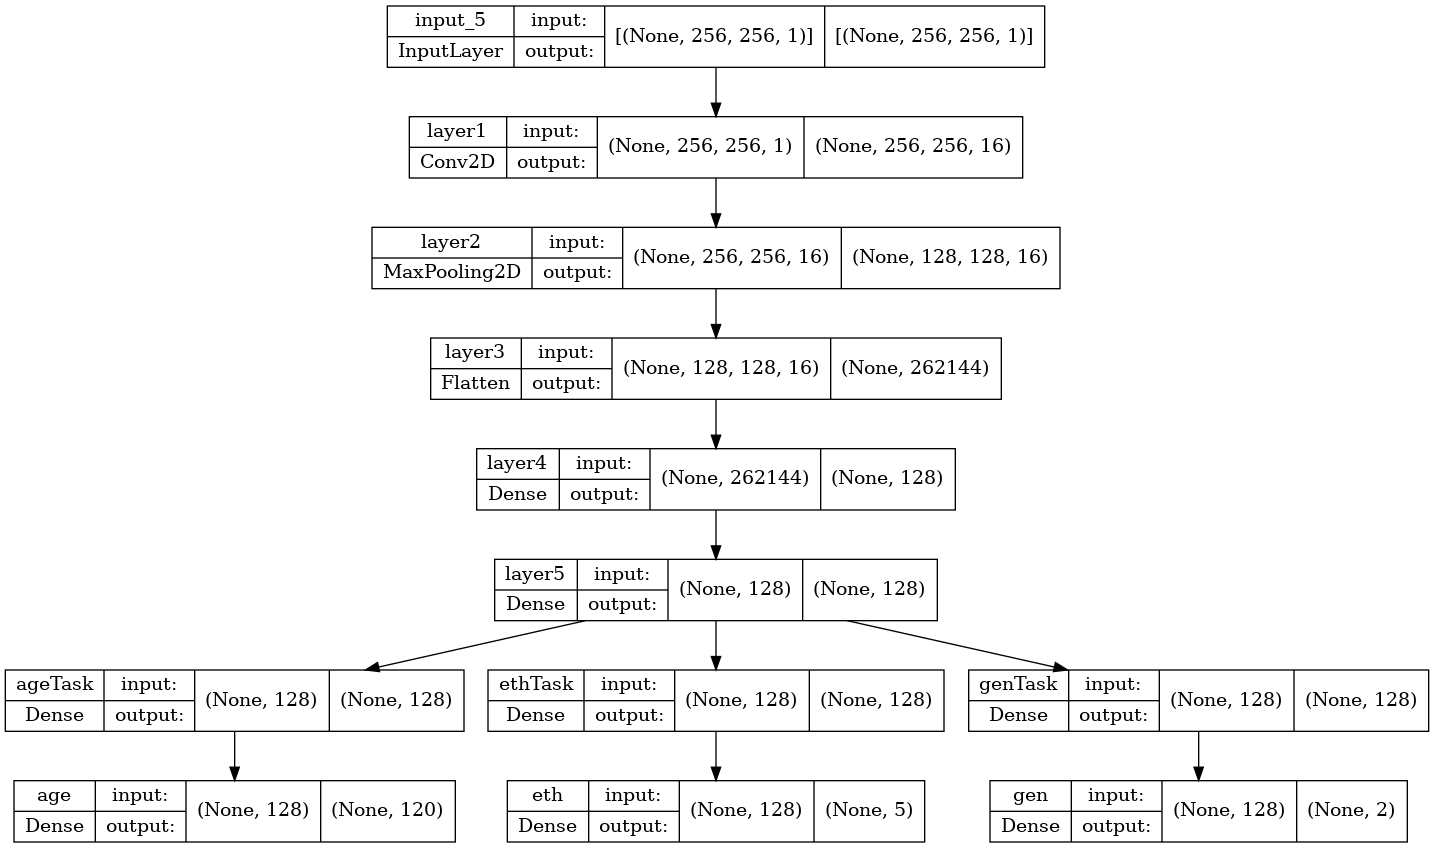

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

Epoch 1/2
  6/940 [..............................] - ETA: 4:47 - loss: 0.9655 - age_loss: 4.7875 - eth_loss: 1.3436 - gen_loss: 0.5778 - age_accuracy: 0.0312 - eth_sparse_top_k_categorical_accuracy: 0.8125 - gen_accuracy: 0.4896

KeyboardInterrupt: 

#### Making predictions on test data (14/100)

In [ ]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions
(4)
result = model.evaluate(test_generator)

294/294 [==============================] - 8s 27ms/step - loss: 0.9860 - age_loss: 4.7875 - eth_loss: 1.3011 - gen_loss: 0.6613 - age_accuracy: 0.0119 - eth_sparse_top_k_categorical_accuracy: 0.8505 - gen_accuracy: 0.4568


In [ ]:
# generate predictions using the test generator
(2)

# extract the ethnicity predictions
(2)
# print the classification report for predicting ethnicity
(2)

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
(2)
# print the classification report for predicting gender
(2)

2

#### Present prediction results on test data(5/100)

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy) |
|-----------------|----------|--------------------|------------------|
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
